Now we will compare to human classified countries.  This was done by human raters using Amazon Mturk.  3,500 articles were classified by the human raters.

In [3]:
# Set up

import numpy as np
import pandas as pd

# Data management & cleaning
import json # to load json files
import gc # to delete files from cache
import os #to get file names in directory
import random #for random sampling of files
import pickle #to save lists
import glob
import statsmodels.api as sm

#pip install pyarrow

# Analysis
import spacy # for named entity recognition

import en_core_web_sm #https://github.com/explosion/spaCy/issues/4577
import country_converter as coco #https://pypi.org/project/country-converter/ #pip install country_converter --upgrade
from sklearn.preprocessing import MultiLabelBinarizer
import re #regular expressions
import pycountry # for regular expresison country names
import wbgapi as wb


# Visualization
import matplotlib.pyplot as plt


path="C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv/"
mturk_path = "C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/01_raw_data/classification_set/"


article_file="C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/mturk_article_classifications.csv"
country_file="C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/mturk_country_scores.csv"

In [4]:
#read in the data
all_files = ['C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_0.csv']

df_full = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_full = df_full[df_full['abstract'].notna()]


df_full=df_full[['paper_id','title','abstract','year','doi', 'venue', 'journal','mag_field_of_study']]

C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\1535963912.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [5]:
#read in the data from mturk
#read in the data
mturk_files = glob.glob(os.path.join(mturk_path, "*.csv"))

df_mturk = pd.concat((pd.read_csv(f) for f in mturk_files), ignore_index=True)

df_mturk=df_mturk[['Input.title','Input.abstract','Input.paper_id','Answer.taskAnswers','WorkerId','WorkTimeInSeconds' ]]
df_mturk.columns=['title','abstract','paper_id.y','taskAnswers','WorkerId','WorkTimeInSeconds']

#remove brackets from taskAnswers
df_mturk['taskAnswers']=df_mturk['taskAnswers'].str.strip('[]')

#flatten json column
df_mturk = df_mturk.join(pd.io.json.json_normalize(df_mturk['taskAnswers'].map(json.loads).tolist()).add_prefix('Answers.'))

#left join df_mturk to df_pd based on title and abstract text
df_final_mturk = pd.merge(df_full, df_mturk, how='right', on=['title','abstract'])
df_pd=df_final_mturk
df_pd=df_pd[['paper_id','title','abstract','year','doi', 'venue', 'journal','mag_field_of_study']]

mturk_paper_index = list(df_final_mturk.index) # this ist just a list of the index/CoreIDs


C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\3424499574.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_mturk = df_mturk.join(pd.io.json.json_normalize(df_mturk['taskAnswers'].map(json.loads).tolist()).add_prefix('Answers.'))


# Spacy/Regex Classifications

In [6]:
#extract GPE
paper_index = list(df_pd.index) # this ist just a list of the index/CoreIDs
nlp = en_core_web_sm.load() #load model; https://github.com/explosion/spaCy/issues/4577
#nlp = spacy.load("en_core_web_sm") # load model

In [7]:
%%time

# a problem here is that the extracted GPEs are saved as lists within the dataframe and I think 
# that takes up a lot of memory
# but in the next step we actually need them as list, so converting it to strings is not really a solution

# https://stackoverflow.com/questions/44395656/applying-spacy-parser-to-pandas-dataframe-w-multiprocessing
#https://spacy.io/api/language#pipe

places = []
counter = 0
manual_batch_size = 1000

for doc in nlp.pipe(df_pd.loc[paper_index,'abstract'].astype('unicode').values,
                    batch_size=20,
                    #n_threads=8,
                    n_process = -1,
                    disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]): 
    
    if len(doc.ents) != 0:
        places.append([ent.as_doc() for ent in doc.ents if ent.label_ in ['GPE']])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        places.append([])
    
    # Creating ONE list of all the extracted GPEs took up too much memory, leading the kernel to die.
    # Therfore, I am saving the results from every 1000 publications directly to the dataframe,
    # and then clear the list.
    if (len(places)%manual_batch_size == 0):
        df_pd.loc[paper_index[(counter*manual_batch_size):(manual_batch_size*(counter + 1))],'places'] = places
        counter += 1
        print(counter/(df_pd.shape[0]/manual_batch_size)) # print out progress
        del places
        gc.collect()
        places = []

C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\dtypes\missing.py:550: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.array(val, copy=False)
<timed exec>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray f

0.2856326763781777


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.5712653527563554


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.8568980291345331
CPU times: total: 15.6 s
Wall time: 53.4 s


In [8]:
%%capture
# use country converter to standarize country names
countries = coco.convert(names=df_pd.loc[paper_index,"places"], to='ISO3', src ="regex", not_found = "nf")
df_pd.loc[paper_index,'countries'] = countries

In [9]:
df_pd[['paper_id','title','abstract', 'places', 'countries']].head(100)

,paper_id,title,abstract,places,countries
0,NaN,Modeling and Hysteresis Compensation in a Thin...,Having a responsive behavior to applied voltag...,[],nf
1,3908655.0,Protective Effects of Soy Oligopeptides in Ult...,Aim. We explored the effects of soy oligopepti...,[],nf
2,3908655.0,Protective Effects of Soy Oligopeptides in Ult...,Aim. We explored the effects of soy oligopepti...,[],nf
3,7292463.0,Headset Bluetooth and cell phone based continu...,The accurate measure of the central temperatur...,[],nf
4,7292463.0,Headset Bluetooth and cell phone based continu...,The accurate measure of the central temperatur...,[],nf
...,...,...,...,...,...
95,208316657.0,Association between flourishing mental health ...,"BACKGROUND ::: Flourishing, defined as the coe...","[(Japan), (Tsukuba, Science, City), (Japan)]",JPN
96,208316657.0,Association between flourishing mental health ...,"BACKGROUND ::: Flourishing, defined as the coe...","[(Japan), (Tsukuba, Science, City), (Japan)]",JPN
97,NaN,Nonlinear dynamic systems fault detection and ...,A novel fault detection and isolation scheme f...,[],nf
98,NaN,Nonlinear dynamic systems fault detection and ...,A novel fault detection and isolation scheme f...,[],nf


In [10]:
%%time
for i in paper_index: #len(df_pd)
    if type(df_pd.loc[i,'countries']) == str:
        df_pd.at[i,"countries"] = df_pd.loc[i,'countries'].split()

CPU times: total: 93.8 ms
Wall time: 81.1 ms


In [11]:
%%time
# Get dummies
#Inspiration: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies 
#Inspiration: https://stackoverflow.com/questions/47209847/is-there-a-method-for-creating-dataframe-of-dummy-variables-from-a-dictionary-of

s = df_pd.loc[paper_index,'countries']


mlb = MultiLabelBinarizer()
df_c = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=paper_index)

#merge with df_pd
df_final = pd.concat([df_pd, df_c], axis=1)
df_final.head()


CPU times: total: 15.6 ms
Wall time: 10.2 ms


,paper_id,title,abstract,year,doi,venue,journal,mag_field_of_study,places,countries,...,USA,UZB,VNM,VUT,XKX,YEM,ZAF,ZMB,ZWE,nf
0,NaN,Modeling and Hysteresis Compensation in a Thin...,Having a responsive behavior to applied voltag...,NaN,NaN,NaN,NaN,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,1
1,3908655.0,Protective Effects of Soy Oligopeptides in Ult...,Aim. We explored the effects of soy oligopepti...,2016.0,10.1155/2016/5846865,Oxidative Medicine and Cellular Longevity,Oxidative Medicine and Cellular Longevity,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,1
2,3908655.0,Protective Effects of Soy Oligopeptides in Ult...,Aim. We explored the effects of soy oligopepti...,2016.0,10.1155/2016/5846865,Oxidative Medicine and Cellular Longevity,Oxidative Medicine and Cellular Longevity,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,1
3,7292463.0,Headset Bluetooth and cell phone based continu...,The accurate measure of the central temperatur...,2010.0,10.1109/IEMBS.2010.5626172,2010 Annual International Conference of the IE...,2010 Annual International Conference of the IE...,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,1
4,7292463.0,Headset Bluetooth and cell phone based continu...,The accurate measure of the central temperatur...,2010.0,10.1109/IEMBS.2010.5626172,2010 Annual International Conference of the IE...,2010 Annual International Conference of the IE...,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,1


In [12]:
test = [{'JPN','USA'}]
mlb.fit_transform(test)

array([[1, 1]])

In [13]:
df_pd.head(40)

,paper_id,title,abstract,year,doi,venue,journal,mag_field_of_study,places,countries
0,NaN,Modeling and Hysteresis Compensation in a Thin...,Having a responsive behavior to applied voltag...,NaN,NaN,NaN,NaN,NaN,[],[nf]
1,3908655.0,Protective Effects of Soy Oligopeptides in Ult...,Aim. We explored the effects of soy oligopepti...,2016.0,10.1155/2016/5846865,Oxidative Medicine and Cellular Longevity,Oxidative Medicine and Cellular Longevity,NaN,[],[nf]
2,3908655.0,Protective Effects of Soy Oligopeptides in Ult...,Aim. We explored the effects of soy oligopepti...,2016.0,10.1155/2016/5846865,Oxidative Medicine and Cellular Longevity,Oxidative Medicine and Cellular Longevity,NaN,[],[nf]
3,7292463.0,Headset Bluetooth and cell phone based continu...,The accurate measure of the central temperatur...,2010.0,10.1109/IEMBS.2010.5626172,2010 Annual International Conference of the IE...,2010 Annual International Conference of the IE...,NaN,[],[nf]
4,7292463.0,Headset Bluetooth and cell phone based continu...,The accurate measure of the central temperatur...,2010.0,10.1109/IEMBS.2010.5626172,2010 Annual International Conference of the IE...,2010 Annual International Conference of the IE...,NaN,[],[nf]
5,9517670.0,Differential Regulation of the Variations Indu...,Adult hippocampal neurogenesis (AHN) augments ...,2010.0,10.1371/journal.pone.0012188,PLoS ONE,PLoS ONE,NaN,[],[nf]
6,9517670.0,Differential Regulation of the Variations Indu...,Adult hippocampal neurogenesis (AHN) augments ...,2010.0,10.1371/journal.pone.0012188,PLoS ONE,PLoS ONE,NaN,[],[nf]
7,201676041.0,What do young women with obesity want from a w...,Purpose ::: Early adulthood is a high-risk tim...,2019.0,10.1007/s40519-019-00763-z,Eating and Weight Disorders - Studies on Anore...,Eating and Weight Disorders - Studies on Anore...,NaN,[],[nf]
8,201676041.0,What do young women with obesity want from a w...,Purpose ::: Early adulthood is a high-risk tim...,2019.0,10.1007/s40519-019-00763-z,Eating and Weight Disorders - Studies on Anore...,Eating and Weight Disorders - Studies on Anore...,NaN,[],[nf]
9,23649097.0,Effects of postural control manipulation on vi...,Purpose/Background: ::: Visuomotor ability is ...,2014.0,NaN,International journal of sports physical therapy,International journal of sports physical therapy,NaN,[],[nf]


## Regular Expressions


In [14]:
# get list of all countries and subdivisions
country_dict = {} 
to_be_removed = ["West", "East", "Center","Centre","North","South",
                 "Western","Eastern","Southern","Northern","Central",
                 "Ouest", "Est", "Sud", "Est", "Nord","Centre-Est","Centre-Sud","Centre-Ouest","Centre-Nord",
                 "Norte", "Este", "Sur", "Oeste",
                 "Has", "Ha", "Male", "Mat", "Delta", "Leon","León","Como","Para","Most","Pool"] #MAT, relevant for subdivisions
for country in pycountry.countries:
    entities = ["\s" + country.name + "[\s,.:]"]
    # THIS CODE IS FOR SUBDIVISIONS: (commented because too slow)
    #for sub_div in pycountry.subdivisions.get(country_code = country.alpha_2):
    #    if sub_div.name not in to_be_removed:
    #    #adding spaces before and allowing for max 1 or zero characters afters (e.g. a comma),
    #    # otherwise segments being picked up
    #        entities.append("\s" + sub_div.name + "[\s,.:]")  
    country_dict[country.alpha_3] = entities

In [15]:
def check_if_country_or_subdiv_present(df, name_of_text_column, country_code_alpha3):
    df_matrix = pd.DataFrame(index=df.index)
    for entity in country_dict[country_code_alpha3]:
        df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)
    df_matrix["present"] = df_matrix.max(axis=1)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df_matrix.sum()) #turn on to analyze sub-div level results
    return df_matrix["present"]
    del df_matrix
    gc.collect()

In [16]:
%time
for country_code_alpha3 in country_dict.keys():
#for country_code_alpha3 in ["ARG"]:
    column_name = country_code_alpha3 + "_regex"
    df_c[column_name] = check_if_country_or_subdiv_present(df_pd, "abstract", country_code_alpha3)
    # Take the maximum SpaCy and %regex detection
    # print("here with", country_code_alpha3)
    if country_code_alpha3 in df_c.columns: #if we already made a column with spacy, combine (inclusively) the results
        df_c[country_code_alpha3] = df_c[[country_code_alpha3,column_name]].max(axis=1) 
        df_c = df_c.drop(columns = [column_name])
    else:
        df_c[country_code_alpha3] = df_c[column_name]
        df_c = df_c.drop(columns = [column_name]) 

CPU times: total: 0 ns
Wall time: 0 ns
\sAruba[\s,.:]    0
present           0
dtype: int64
\sAfghanistan[\s,.:]    10
present                 10
dtype: int64
\sAngola[\s,.:]    2
present            2
dtype: int64
\sAnguilla[\s,.:]    0
present              0
dtype: int64
\sÅland Islands[\s,.:]    0
present                   0
dtype: int64
\sAlbania[\s,.:]    0
present             0
dtype: int64
\sAndorra[\s,.:]    0
present             0
dtype: int64
\sUnited Arab Emirates[\s,.:]    1
present                          1
dtype: int64
\sArgentina[\s,.:]    1
present               1
dtype: int64
\sArmenia[\s,.:]    2
present             2
dtype: int64
\sAmerican Samoa[\s,.:]    0
present                    0
dtype: int64
\sAntarctica[\s,.:]    1
present                1
dtype: int64
\sFrench Southern Territories[\s,.:]    0
present                                 0
dtype: int64
\sAntigua and Barbuda[\s,.:]    0
present                         0
dtype: int64
\sAustralia[\s,.:]    43
presen

C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sChina[\s,.:]    79
present           79
dtype: int64
\sCôte d'Ivoire[\s,.:]    0
present                   0
dtype: int64
\sCameroon[\s,.:]    1
present              1
dtype: int64
\sCongo, The Democratic Republic of the[\s,.:]    0
present                                           0
dtype: int64
\sCongo[\s,.:]    2
present           2
dtype: int64
\sCook Islands[\s,.:]    0
present                  0
dtype: int64
\sColombia[\s,.:]    2
present              2
dtype: int64
\sComoros[\s,.:]    0
present             0
dtype: int64
\sCabo Verde[\s,.:]    0
present                0
dtype: int64
\sCosta Rica[\s,.:]    3
present                3
dtype: int64
\sCuba[\s,.:]    2
present          2
dtype: int64
\sCuraçao[\s,.:]    0
present             0
dtype: int64
\sChristmas Island[\s,.:]    0
present                      0
dtype: int64
\sCayman Islands[\s,.:]    0
present                    0
dtype: int64
\sCyprus[\s,.:]    4
present            4
dtype: int64
\sCzechia[\s,.:]    0
present

C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sFaroe Islands[\s,.:]    0
present                   0
dtype: int64
\sMicronesia, Federated States of[\s,.:]    0
present                                     0
dtype: int64
\sGabon[\s,.:]    0
present           0
dtype: int64
\sUnited Kingdom[\s,.:]    10
present                    10
dtype: int64
\sGeorgia[\s,.:]    3
present             3
dtype: int64
\sGuernsey[\s,.:]    0
present              0
dtype: int64
\sGhana[\s,.:]    5
present           5
dtype: int64
\sGibraltar[\s,.:]    0
present               0
dtype: int64
\sGuinea[\s,.:]    0
present            0
dtype: int64
\sGuadeloupe[\s,.:]    0
present                0
dtype: int64
\sGambia[\s,.:]    1
present            1
dtype: int64
\sGuinea-Bissau[\s,.:]    0
present                   0
dtype: int64
\sEquatorial Guinea[\s,.:]    0
present                       0
dtype: int64
\sGreece[\s,.:]    16
present            16
dtype: int64
\sGrenada[\s,.:]    0
present             0
dtype: int64
\sGreenland[\s,.:]    1
present      

C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sMorocco[\s,.:]    1
present             1
dtype: int64
\sMonaco[\s,.:]    0
present            0
dtype: int64
\sMoldova, Republic of[\s,.:]    0
present                          0
dtype: int64
\sMadagascar[\s,.:]    0
present                0
dtype: int64
\sMaldives[\s,.:]    0
present              0
dtype: int64
\sMexico[\s,.:]    12
present            12
dtype: int64
\sMarshall Islands[\s,.:]    0
present                      0
dtype: int64
\sNorth Macedonia[\s,.:]    0
present                     0
dtype: int64
\sMali[\s,.:]    1
present          1
dtype: int64
\sMalta[\s,.:]    1
present           1
dtype: int64
\sMyanmar[\s,.:]    2
present             2
dtype: int64
\sMontenegro[\s,.:]    3
present                3
dtype: int64
\sMongolia[\s,.:]    0
present              0
dtype: int64
\sNorthern Mariana Islands[\s,.:]    0
present                              0
dtype: int64
\sMozambique[\s,.:]    0
present                0
dtype: int64
\sMauritania[\s,.:]    0
present         

C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sSint Maarten (Dutch part)[\s,.:]    0
present                               0
dtype: int64
\sSeychelles[\s,.:]    0
present                0
dtype: int64
\sSyrian Arab Republic[\s,.:]    0
present                          0
dtype: int64
\sTurks and Caicos Islands[\s,.:]    0
present                              0
dtype: int64
\sChad[\s,.:]    2
present          2
dtype: int64
\sTogo[\s,.:]    0
present          0
dtype: int64
\sThailand[\s,.:]    13
present              13
dtype: int64
\sTajikistan[\s,.:]    1
present                1
dtype: int64
\sTokelau[\s,.:]    0
present             0
dtype: int64
\sTurkmenistan[\s,.:]    0
present                  0
dtype: int64
\sTimor-Leste[\s,.:]    0
present                 0
dtype: int64
\sTonga[\s,.:]    0
present           0
dtype: int64
\sTrinidad and Tobago[\s,.:]    0
present                         0
dtype: int64
\sTunisia[\s,.:]    3
present             3
dtype: int64
\sTurkey[\s,.:]    27
present            27
dtype: int64
\sTuval

C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sHoly See (Vatican City State)[\s,.:]    0
present                                   0
dtype: int64
\sSaint Vincent and the Grenadines[\s,.:]    0
present                                      0
dtype: int64
\sVenezuela, Bolivarian Republic of[\s,.:]    0
present                                       0
dtype: int64
\sVirgin Islands, British[\s,.:]    0
present                             0
dtype: int64
\sVirgin Islands, U.S.[\s,.:]    0
present                          0
dtype: int64
\sViet Nam[\s,.:]    0
present              0
dtype: int64
\sVanuatu[\s,.:]    1
present             1
dtype: int64
\sWallis and Futuna[\s,.:]    0
present                       0
dtype: int64
\sSamoa[\s,.:]    0
present           0
dtype: int64
\sYemen[\s,.:]    2
present           2
dtype: int64
\sSouth Africa[\s,.:]    19
present                  19
dtype: int64
\sZambia[\s,.:]    4
present            4
dtype: int64
\sZimbabwe[\s,.:]    3
present              3
dtype: int64


In [17]:
#merge with df_pd
df_final = pd.concat([df_pd, df_c], axis=1)
df_final.head()

,paper_id,title,abstract,year,doi,venue,journal,mag_field_of_study,places,countries,...,TTO,TUV,UMI,VAT,VCT,VEN,VGB,VIR,WLF,WSM
0,NaN,Modeling and Hysteresis Compensation in a Thin...,Having a responsive behavior to applied voltag...,NaN,NaN,NaN,NaN,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,0
1,3908655.0,Protective Effects of Soy Oligopeptides in Ult...,Aim. We explored the effects of soy oligopepti...,2016.0,10.1155/2016/5846865,Oxidative Medicine and Cellular Longevity,Oxidative Medicine and Cellular Longevity,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,0
2,3908655.0,Protective Effects of Soy Oligopeptides in Ult...,Aim. We explored the effects of soy oligopepti...,2016.0,10.1155/2016/5846865,Oxidative Medicine and Cellular Longevity,Oxidative Medicine and Cellular Longevity,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,0
3,7292463.0,Headset Bluetooth and cell phone based continu...,The accurate measure of the central temperatur...,2010.0,10.1109/IEMBS.2010.5626172,2010 Annual International Conference of the IE...,2010 Annual International Conference of the IE...,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,0
4,7292463.0,Headset Bluetooth and cell phone based continu...,The accurate measure of the central temperatur...,2010.0,10.1109/IEMBS.2010.5626172,2010 Annual International Conference of the IE...,2010 Annual International Conference of the IE...,NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_s = df_c.sum().to_frame(name = "class_papers")

# Show 50 countries with highest number of publications
df_s = df_s.sort_values(by = "class_papers", ascending = False)
df_s.head(50)


,class_papers
nf,2745
USA,126
CHN,91
IND,53
AUS,47
JPN,37
DEU,37
CAN,31
TUR,30
NGA,29


# Human Classifications

In [19]:
%%capture
# use country converter to standarize country names
countries = coco.convert(names=df_final_mturk.loc[mturk_paper_index,"Answers.country"], to='ISO3', src ="regex", not_found = "nf", enforce_list=True)
df_final_mturk.loc[mturk_paper_index,'countries'] = countries

In [20]:
#now produce in similar format as df_final


# Get dummies

#Inspiration: https://stackoverflow.com/questions/47209847/is-there-a-method-for-creating-dataframe-of-dummy-variables-from-a-dictionary-of
s = df_final_mturk.loc[mturk_paper_index,'countries']

mlb = MultiLabelBinarizer()
df_c_mturk = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=mturk_paper_index)
#df_c_mturk=df_c_mturk[df_c_mturk.columns.intersection(df_c.columns)]


#merge with df_pd
df_final_mturk = pd.concat([df_final_mturk, df_c_mturk], axis=1)


In [21]:

#get country numbers based on df_c_mturk
df_s_mturk = df_c_mturk.sum().to_frame(name = "mturk_papers")

# Show 50 countries with highest number of publications
df_s_mturk = df_s_mturk.sort_values(by = "mturk_papers", ascending = False)





In [22]:
#join df_s_mturk with df_s
df_s_mturk = df_s_mturk.join(df_s, how='left')
df_s_mturk.head(50)


,mturk_papers,class_papers
nf,2041,2745
USA,436,126
CHN,111,91
GBR,96,25
IND,59,53
AUS,51,47
IDN,46,27
CAN,46,31
DEU,41,37
JPN,34,37


C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\1901430827.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_s_mturk["class_papers"].values)


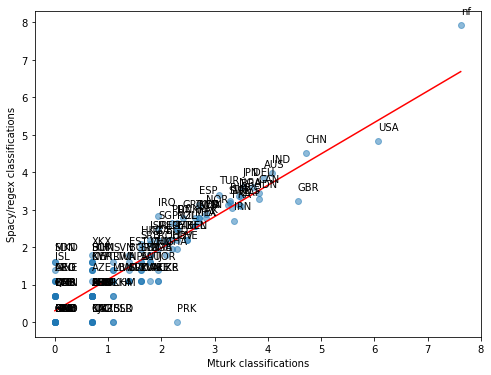

In [23]:
# Scatter of mturk classifications and spacy/regex classifications
x = np.log(df_s_mturk["mturk_papers"].values)
y = np.log(df_s_mturk["class_papers"].values)
txt=df_s_mturk.index.to_list()

idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
for i, lab in enumerate(txt):
    plt.annotate(lab, (x[i], y[i]+.3))
plt.xlabel("Mturk classifications")
plt.ylabel("Spacy/regex classifications")
plt.show()

In [24]:
#linear regression

x = df_s_mturk["mturk_papers"].values
y = df_s_mturk["class_papers"].values
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     4561.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):          1.73e-106
Time:                        12:08:59   Log-Likelihood:                -703.38
No. Observations:                 138   AIC:                             1411.
Df Residuals:                     136   BIC:                             1417.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4555      3.434     -1.880      0.0

## Classify Papers by Data Use - 'Naive' Approach with Regular Expressions

### Classification

We first try a 'naive' approach. We assume that if any of the following words appear in the title, abstract, or topics field, the paper uses data. If none of the words appear, the paper doesn't use data. The apporoach is case-insensitive.

Reference word list 1: data

Reference word list 2: data, survey, census

Reference word list 3: data, survey, census, panel, cross-section, time-series

Reference word list 4: data, survey, census, panel, cross-section, time-series, ...

Reference word list 4 is inspired 'statistical terms' in Paris21 (2021) (saved in the literature folder).

In [25]:
%%time
print("Working on list 1 ...")
df_final_mturk["data_use_1"] = df_pd["abstract"].str.contains('data', flags=re.IGNORECASE, regex=True).astype(int)
print("Working on list 2 ...")
df_final_mturk["data_use_2"] = df_pd["abstract"].str.contains('data|survey|census', flags=re.IGNORECASE, regex=True).astype(int)
print("Working on list 3 ...")
df_final_mturk["data_use_3"] = df_pd["abstract"].str.contains('data|survey|census|panel|cross.*?section|time.*?series', flags=re.IGNORECASE, regex=True).astype(int)
print("Working on list 4 ...")
reference_word_list_4 = "data|survey|census|panel|cross.*?section|Multinomial|Logit|Estimator|Cohort.*?level|Nonlinear|Covariance|Variance|Residual|Sampling|Sample|Instrumental Variable|Kernel|Probit|Poisson|Panel|Quantile|Arellano.*?bond|Confounding|Non.*?random|Randomisation|Statistical Significance|Statistically Significant|Statistical Power|Autoregressive|Fixed.*?Effects|First.*?differences|Central Limit|Stochastic|Autocorrelation|Upward Bias|Downward Bias|Difference.*?in.*?Difference|Bayes|Endogenous|Misspecification|Imputation|Semiparametric|Mean|Mode|Median|Confidence Interval|P.*?value|Heteroskedastic|Time series|Parameter|Granger|Multivariate|Cluster|Chi.*?square|Dummy|Deviation|Coefficient|Likelihood|Conditional|Ceteris.*?paribus|Regression|Data|Cross.*?section|Heckman|Heterogeneity|Residual|Hot deck|Cold deck|standard error|standard deviation|Longitudinal|Counterfactual|Propensity|Exogenous|Microdata|Regressor|Multicollinearity|Attrition|Odds ratio|Polynomial|Propensity|score|Quasi.*?experiment|Treatment group|Control group|BLUE|OLS|metric|indicator|outcome measure|random forest|lasso|ridge|test error|out.*?of.*?sample|neural net"
df_final_mturk["data_use_4"] = df_pd["abstract"].str.contains(reference_word_list_4, flags=re.IGNORECASE, regex=True).astype(int)
print("Done")

df_final_mturk["data_use_mturk"]=df_final_mturk['Answers.data_use'].apply(lambda x: 1 if 'Yes' in x else 0)

#df_pd["data_use_1"] = df_pd["text"].str.contains('data', flags=re.IGNORECASE, regex=True).astype(int)
#df_pd["data_use_1"] = df_pd["text"].str.contains('data', flags=re.IGNORECASE, regex=True).astype(int)

Working on list 1 ...
Working on list 2 ...
Working on list 3 ...
Working on list 4 ...
Done
CPU times: total: 4.77 s
Wall time: 4.93 s


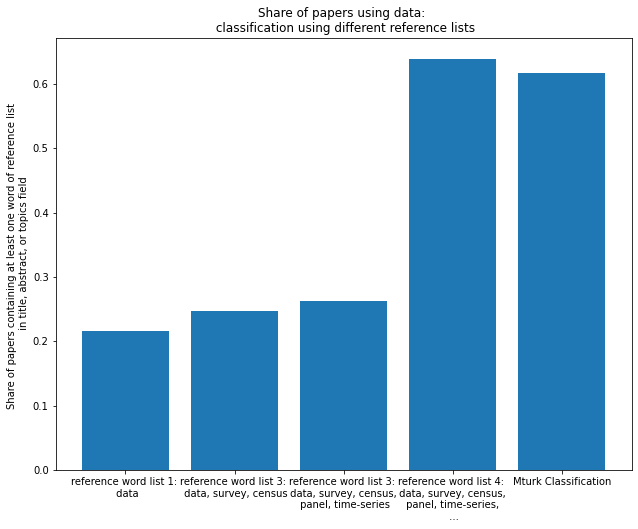

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
lists = ['reference word list 1: \n data', 'reference word list 3: \n data, survey, census', 'reference word list 3: \n data, survey, census, \n panel, time-series', 'reference word list 4: \n data, survey, census, \n panel, time-series, \n ...', 'Mturk Classification']
data_use_rates = [df_final_mturk["data_use_1"].mean(),df_final_mturk["data_use_2"].mean(),df_final_mturk["data_use_3"].mean(),df_final_mturk["data_use_4"].mean(),df_final_mturk["data_use_mturk"].mean()]
ax.bar(lists,data_use_rates)
ax.set_title('Share of papers using data: \n classification using different reference lists')
plt.ylabel("Share of papers containing at least one word of reference list \n in title, abstract, or topics field")
plt.show()


In [27]:
#plot of data_use_4 versus data_use_mturk
from sklearn.metrics import confusion_matrix

y_true = df_final_mturk["data_use_mturk"].values
y_pred = df_final_mturk["data_use_4"].values

confusion_matrix(y_true, y_pred)

array([[ 695,  649],
       [ 568, 1589]], dtype=int64)

In [28]:
#Accuracy

from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.6523850328477577

In [29]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average='micro')

0.6523850328477577

In [30]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average='micro')

0.6523850328477577

In [31]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='micro')


0.6523850328477577

# Country Rankings

Among articles that use data, rank number of articles per country.  Scale by country GDP



In [32]:
#get index of countries with data_use_4 = 1
data_use_index=df_final_mturk[df_final_mturk["data_use_4"] == 1].index

#filter countries with data_use_4 = 1
df_c_data_use_4 = df_c.loc[data_use_index]

#get country numbers based on df_c_mturk
df_s_data_use_4 = df_c_data_use_4.sum().to_frame(name = "data_use_class_papers")

# Show 50 countries with highest number of publications
df_s_data_use_4 = df_s_data_use_4.sort_values(by = "data_use_class_papers", ascending = False)


In [33]:
#get index of countries with data_use_mturk = 1
data_use_index=df_final_mturk[df_final_mturk["data_use_mturk"] == 1].index

#filter countries with data_use_4 = 1
df_c_data_use_mturk = df_c_mturk.loc[data_use_index]

#get country numbers based on df_c_mturk
df_s_data_use_mturk = df_c_data_use_mturk.sum().to_frame(name = "data_use_mturk_papers")

# Show 50 countries with highest number of publications
df_s_data_use_mturk = df_s_data_use_mturk.sort_values(by = "data_use_mturk_papers", ascending = False)


In [34]:
df_c_data_use_4.sum()

AFG    6
AGO    0
ARE    3
ARG    2
ARM    1
      ..
VEN    0
VGB    0
VIR    0
WLF    0
WSM    0
Length: 251, dtype: int64

In [35]:
#join df_s_mturk with df_s
df_s_mturk = df_s_mturk.join(df_s_data_use_mturk, how='left')
df_s_mturk = df_s_mturk.join(df_s_data_use_4, how='left')

df_s_mturk.head(50)

,mturk_papers,class_papers,data_use_mturk_papers,data_use_class_papers
nf,2041,2745,1033,1733
USA,436,126,328,70
CHN,111,91,91,65
GBR,96,25,75,15
IND,59,53,48,32
AUS,51,47,33,28
IDN,46,27,38,16
CAN,46,31,37,18
DEU,41,37,34,25
JPN,34,37,30,22


C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\4115800398.py:2: RuntimeWarning: divide by zero encountered in log
  x = np.log(df_s_mturk["data_use_mturk_papers"].values)
C:\Users\wb469649\AppData\Local\Temp\ipykernel_11364\4115800398.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_s_mturk["data_use_class_papers"].values)


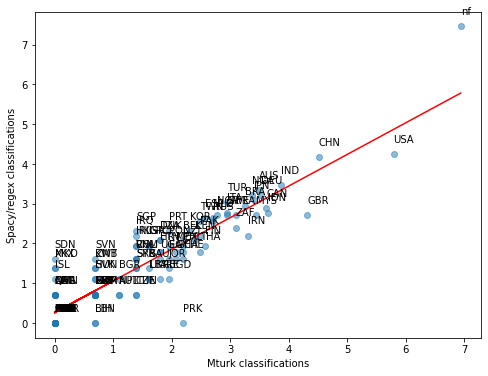

In [36]:
# Scatter of mturk classifications and spacy/regex classifications
x = np.log(df_s_mturk["data_use_mturk_papers"].values)
y = np.log(df_s_mturk["data_use_class_papers"].values)
txt=df_s_mturk.index.to_list()

idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
for i, lab in enumerate(txt):
    plt.annotate(lab, (x[i], y[i]+.3))
plt.xlabel("Mturk classifications")
plt.ylabel("Spacy/regex classifications")
plt.show()

In [37]:
#linear regression

x = df_s_mturk["data_use_mturk_papers"].values
y = df_s_mturk["data_use_class_papers"].values
x = sm.add_constant(x)

model = sm.OLS(y, x).fit(cov_type="HC3")
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1.449
Date:                Wed, 03 Aug 2022   Prob (F-statistic):              0.231
Time:                        12:09:09   Log-Likelihood:                -707.60
No. Observations:                 138   AIC:                             1419.
Df Residuals:                     136   BIC:                             1425.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8719     11.455     -0.687      0.4

In [38]:
df_final_mturk.reset_index().to_csv(article_file)
df_s_mturk.reset_index().to_csv(country_file)
